In [ ]:
!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip

--2021-07-30 12:16:41--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.124.90
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.124.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1061576029 (1012M) [binary/octet-stream]
Saving to: ‘dataset52a7b21.zip’

dataset52a7b21.zip  100%[===================>]   1012M  13.8MB/s    in 71s     

2021-07-30 12:17:53 (14.2 MB/s) - ‘dataset52a7b21.zip’ saved [1061576029/1061576029]



In [ ]:
!unzip /content/dataset52a7b21.zip

Archive:  /content/dataset52a7b21.zip
   creating: dataset/
  inflating: dataset/train.csv       
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/.~lock.train.csv#  


In [ ]:
!mv /content/dataset/ /content/drive/MyDrive/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/dataset/train.csv'
test_path = '/content/drive/MyDrive/dataset/test.csv'
sample_sub_path = '/content/drive/MyDrive/dataset/sample_submission.csv'

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import csv
import tensorflow as tf 
import tensorflow_hub as hub

In [ ]:
# Loading in the data 
train_data = pd.read_csv(train_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)

# Loading the test dataset 
test_data = pd.read_csv(test_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)
# # Sample submission 
sample_sub = pd.read_csv(sample_sub_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)



## Working with a subset 

In [ ]:
test_data.head()

,PRODUCT_ID,TITLE,DESCRIPTION,BULLET_POINTS,BRAND
0,1,"Command 3M Small Kitchen Hooks, White, Decorat...",Sale Unit: PACK,[INCLUDES - 9 hooks and 12 small indoor strips...,Command
1,2,O'Neal Jump Hardware JAG Unisex-Adult Glove (B...,Synthetic leather palm with double-layer thumb...,[Silicone printing for a better grip. Long las...,O'Neal
2,3,"NFL Detroit Lions Portable Party Fridge, 15.8 ...",Boelter Brands lets you celebrate your favorit...,[Runs on 12 Volt DC Power or 110 Volt AC Power...,Boelter Brands
3,4,Panasonic Single Line KX-TS880MX Corded Phone ...,Features: 50 Station Phonebook Corded Phone Al...,Panasonic Landline Phones doesn't come with a ...,Panasonic
4,5,Zero Baby Girl's 100% Cotton Innerwear Bloomer...,"Zero Baby Girl Panties Set. 100% Cotton, Breat...","[Zero Baby Girl Panties, Pack of 6, 100% Cotto...",Zero


#### Multi-Input Model 

In [ ]:
# Getting the subset of the sample 
train_sample = train_data.sample(frac= 1 , random_state= 42)
#val_sample = train_data.sample(frac = 0.1 , random_state= 3)

In [ ]:
# X = train_sample.drop('BROWSE_NODE_ID' , axis = 1)
# y = train_sample['BROWSE_NODE_ID']

# X.shape , y.shape
# # from sklearn.model_selection import StratifiedShuffleSplit
# # strat_split = StratifiedShuffleSplit(n_splits = 1 , test_size = 0.3 , train_size= 0.7  , random_state = 42)
# train_sample.head().T
# y

# for train_index , test_index in strat_split.split(X, y):
#   X_train , X_test = X[train_index] , X[test_index]
#   y_train , y_test = y[train_index] , y[test_index]
# train_sample.BROWSE_NODE_ID.value_counts()
# train_sample.shape , val_sample.shape
# train_sample.head()
# test_data.head(10)
# train_data.isna().sum()
# train_sample['Info'] = train_sample.DESCRIPTION.astype(str) + '  '+  train_sample.BULLET_POINTS.astype(str)
# train_sample.head(10)
# train_sample['BULLET_POINTS']
# train_sample['BROWSE_NODE_ID']
# train_sample[['TITLE' , 'Info']].values

In [ ]:
new_train_sample = train_sample.copy()
new_train_sample.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
2297143,"Amsik®Blind Spot Round Mirror Black, (Real Gla...",The mirrors easily mount to the vehicle's left...,"[It is small, but it is smart mirror, and work...",AMSIK,32296
2078681,Nivea Face Sun Block Whitening Cream SPF 50 Pa...,Nivea Sun Fac Sun Block Whitening Cream Spf 50...,NIVEA face SUN Block Whitening Cream SPF 50 PA ++,Nivea,35
1125035,ROZVEH Women's Shift Brown Dress,"<p>Super Fine Rayon,&nbsp;Brown Floral Print d...","[Material: Super Fine Rayon, Brown Floral Prin...",ROZVEH,1724
1928801,Narayan Creation Pashmina Palazzo Suit Dupatta...,Narayan creatins pashmina unstitched palazzo s...,NaN,Generic,465
864509,Q-rious Women's Silicon Strap Spagettis/Camiso...,Trendy Q-rious Spagetti with sequin detachable...,"[Silicon and Elastic strap option,Detachable S...",Q-rious,2003


In [ ]:
new_train_sample = new_train_sample.drop(columns = ['DESCRIPTION' , 'BULLET_POINTS'] , axis = 1)

In [ ]:
new_train_sample

,TITLE,BRAND,BROWSE_NODE_ID
2297143,"Amsik®Blind Spot Round Mirror Black, (Real Gla...",AMSIK,32296
2078681,Nivea Face Sun Block Whitening Cream SPF 50 Pa...,Nivea,35
1125035,ROZVEH Women's Shift Brown Dress,ROZVEH,1724
1928801,Narayan Creation Pashmina Palazzo Suit Dupatta...,Generic,465
864509,Q-rious Women's Silicon Strap Spagettis/Camiso...,Q-rious,2003
...,...,...,...
1692743,Zemic Baby Waterproof Double Sided Mat (6 X 5 ...,Zemic,1217
2356330,The Design Cart Stainless Steel Style A Needle...,The Design Cart,21895
2229084,SOCH Women's Cotton Straight Kurta NC KT 4402-...,Soch,1251
2768307,Kuber Industries 100 Percent Cotton 144 TC Sin...,Kuber Industries,1084


In [ ]:
# Are there 9919 classes 
(new_train_sample.BROWSE_NODE_ID > 9919)
new_train_sample = new_train_sample.drop(new_train_sample[new_train_sample.BROWSE_NODE_ID > 9919].index,axis = 0 )

# Creating a token level embedding 

In [ ]:
# # Picking up the train text data 
# info_train_sentences = new_train_sample['Info'].to_list()
# title_train_sentences = new_train_sample['TITLE'].astype(str).to_list()

# # Now our val dataset 


# len(info_train_sentences) , len(title_train_sentences)

# title_train_sentences[:10]
# # Average sequence length 
# info_sent_lens = [len(sentence.split()) for sentence in info_train_sentences]
# title_sent_lens = [len(title.split()) for title in title_train_sentences]

# avg_sent_len_info = np.mean(info_sent_lens)
# avg_sent_len_title = np.mean(title_sent_lens)

# avg_sent_len_info , avg_sent_len_title
# round(avg_sent_len_info) , round(avg_sent_len_title)
# # Distribution of the tokens 
# plt.hist(info_sent_lens , bins = 7);
# plt.hist(title_sent_lens , bins = 7);
# # How long of a sentence covers 95% of a length 
# info_output_seq_len = int(np.percentile(info_sent_lens , 95))
# title_output_seq_len = int(np.percentile(title_sent_lens , 95))

# info_output_seq_len , title_output_seq_len
# # Maximum sentence in the training sentence of both info and title 
# max(info_sent_lens) , max(title_sent_lens)
# round(len(info_train_sentences) / 6)
# from random import sample 
# little_info_train_sentences = sample(info_train_sentences ,683837)
# len(little_info_train_sentences)
# # Creating a text vectorizer layer for info (token level embedding)
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# info_text_vect_token_layer = TextVectorization(max_tokens= 5000 , 
#                                                output_sequence_length = info_output_seq_len)

# # Adapting the layer on the train data 
# info_text_vect_token_layer.adapt(little_info_train_sentences)
# # Test out text vectorizer
# import random
# target_sentence = random.choice(info_train_sentences)
# print(f"Text:\n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text:\n{info_text_vect_token_layer([target_sentence])}")
# # Creating a text vectorizer layer for title (token level embedding)
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# title_text_vect_token_layer = TextVectorization(max_tokens= 3000 , 
#                                                output_sequence_length = title_output_seq_len)

# # Adapting the layer on the train data 
# title_text_vect_token_layer.adapt(title_train_sentences)
# # Test out text vectorizer (title)
# import random
# target_sentence = random.choice(title_train_sentences)
# print(f"Text:\n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text:\n{title_text_vect_token_layer([target_sentence])}")
# # Now one hot encoding the labels 
# from sklearn.preprocessing import OneHotEncoder
# one_hot_encoder = OneHotEncoder(sparse = False)
# sample_train_labels_one_hot = one_hot_encoder.fit_transform()

# trying to make model with universal scentence encoder 


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
new_train_sample = new_train_sample.drop(new_train_sample[new_train_sample.TITLE.isna()].index, axis = 0 )

In [ ]:
new_train_sample.isna().sum()

TITLE                 0
BRAND             48577
BROWSE_NODE_ID        0
dtype: int64

In [ ]:
base_layer_1 = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable = False)


In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
x = base_layer_1(inputs)
x = tf.keras.layers.Dense(264, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation= 'relu')(x)
outputs = tf.keras.layers.Dense(9919, activation ='softmax')(x)
model = tf.keras.Model(inputs, outputs)

NameError: ignored

In [ ]:
model.summary()

In [ ]:
model.compile(loss =tf.keras.losses.sparse_categorical_crossentropy, 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = 'accuracy')

In [ ]:
train_dataset_inputs= tf.data.Dataset.from_tensor_slices(new_train_sample['TITLE'].to_numpy().astype(np.str))
train_dataset_outputs = tf.data.Dataset.from_tensor_slices(new_train_sample['BROWSE_NODE_ID'].to_numpy())
train_dataset = tf.data.Dataset.zip((train_dataset_inputs, train_dataset_outputs))

In [ ]:
max(new_train_sample['BROWSE_NODE_ID'])

9918

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
first_model = model.fit(train_dataset,
                        # steps_per_epoch= len(train_dataset)*0.1,
                        epochs =2)

Epoch 1/2
161239/161239 [==============================] - 1591s 10ms/step - loss: 1.5212 - accuracy: 0.6704
Epoch 2/2
161239/161239 [==============================] - 1605s 10ms/step - loss: 1.5572 - accuracy: 0.6657


In [ ]:
model.save('/content/drive/MyDrive/amazonMLMOdel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/amazonMLMOdel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/amazonMLMOdel/assets


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_data.TITLE.to_numpy().astype(np.str))

In [ ]:
predictions = model.predict(test_data.TITLE.to_numpy().astype(np.str))

AttributeError: ignored

In [ ]:
predictions

array([[6.5257482e-04, 1.4555699e-03, 2.6876099e-10, ..., 5.9115803e-11,
        5.9682731e-11, 2.5518340e-14],
       [3.4974320e-05, 6.4715359e-06, 1.1606459e-09, ..., 2.3866509e-10,
        2.4213978e-10, 5.7219181e-09],
       [2.5419535e-05, 4.4640154e-02, 4.5862314e-11, ..., 8.0822822e-12,
        8.1775533e-12, 1.7029080e-16],
       ...,
       [1.3493769e-05, 1.3216479e-09, 2.0575978e-12, ..., 3.5456870e-13,
        3.5617513e-13, 1.2033014e-19],
       [1.0833445e-08, 1.9925132e-17, 2.5931163e-14, ..., 8.9276536e-15,
        8.7166543e-15, 3.6360047e-27],
       [7.9640799e-05, 1.8017005e-10, 4.1103575e-11, ..., 8.9082127e-12,
        8.8726708e-12, 1.5820127e-13]], dtype=float32)

In [ ]:
prediction_values = np.argmax(predictions,axis =1)

 loading the model 

In [ ]:
Model_1 = tf.keras.models.load_model('/content/drive/MyDrive/amazonMLMOdel')

In [ ]:
Model_1.evaluate(train_dataset.take(2))

2/2 [==============================] - 0s 12ms/step - loss: 1.7172 - accuracy: 0.6875


[1.7172269821166992, 0.6875]

In [ ]:
!nvidia-smi

Fri Jul 30 17:55:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    39W / 300W |   2629MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# building another model 


In [ ]:
base_layer_2 = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128/2', trainable = False)

In [ ]:
base_layer_3 = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2',trainable = False)

In [ ]:
import tensorflow.keras.layers as layers

# Setting up input/output for title 
title_inputs = layers.Input(shape = [] , dtype = tf.string , name = 'title_input')
title_embed = base_layer_3(title_inputs)
title_outputs = layers.Dense(128 , activation = 'relu')(title_embed)
title_model = tf.keras.Model(inputs = title_inputs , outputs = title_outputs)



# Setting up input/outputs for info 
info_inputs = layers.Input(shape = [] , dtype= tf.string , name = 'Info_input')
info_embed = base_layer_3(info_inputs)
# info_lstm = layers.LSTM(50 , activation= 'tanh')(info_embed)
x = layers.Dense(264,activation = 'relu')(info_embed)
x = layers.Dense(256, activation ='relu')(x)
info_outputs = layers.Dense(128 , activation = 'relu')(x)
info_model = tf.keras.Model(inputs = info_inputs , outputs = info_outputs)


# Concatenating title and info inputs (hybrid)
title_info_concat = layers.Concatenate(name = 'title_info_hybrid')([title_model.output , info_model.output])


# Creating output layer 
# com_dropout = layers.Dropout(0.5)(title_info_concat)
com_dense = layers.Dense(512 , activation= 'relu')(title_info_concat)
# fin_drop = layers.Dropout(0.4)(com_dense)
output_layer = layers.Dense(9919, activation ='softmax')(com_dense)


# Constructing model with title and info inputs 
mult_model = tf.keras.Model(inputs = [title_model.input , info_model.input], 
                            outputs = output_layer , name = 'multi_input_model_1')

# Summary of the model 
mult_model.summary()

Model: "multi_input_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
Info_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      (None, 128)          124642688   title_input[0][0]                
                                                                 Info_input[0][0]                 
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 264)          34056       keras_layer_2[1

In [ ]:
new_train_sample.isna().sum()

TITLE                 0
BRAND             48577
BROWSE_NODE_ID        0
dtype: int64

In [ ]:
new_train_sample.fillna(value = 'NAN').isna().sum()

TITLE             0
BRAND             0
BROWSE_NODE_ID    0
dtype: int64

In [ ]:
new_train_sample = new_train_sample.fillna(value = 'NAN')

In [ ]:
training_dataset_1_inputs = tf.data.Dataset.from_tensor_slices((new_train_sample['TITLE'].to_numpy().astype(np.str), new_train_sample['BRAND'].to_numpy().astype(np.str)))

In [ ]:
training_dataset_1_outputs = tf.data.Dataset.from_tensor_slices(new_train_sample['BROWSE_NODE_ID'].to_numpy())

In [ ]:
training_dataset_1 = tf.data.Dataset.zip((training_dataset_1_inputs,training_dataset_1_outputs)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# compiling the model 
mult_model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ['accuracy'])

In [ ]:
#fitting the model 
model_1 = mult_model.fit(training_dataset_1, 
                        #  steps_per_epoch = len(training_dataset_1)*0.1 ,
                         epochs = 3)

Epoch 1/3
80620/80620 [==============================] - 431s 5ms/step - loss: 1.5471 - accuracy: 0.6635
Epoch 2/3
80620/80620 [==============================] - 432s 5ms/step - loss: 1.5670 - accuracy: 0.6606
Epoch 3/3
80620/80620 [==============================] - 432s 5ms/step - loss: 1.5889 - accuracy: 0.6569


In [ ]:
mult_model.save('/content/drive/MyDrive/mult_model_normalization_correct')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mult_model_normalization_correct/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/mult_model_normalization_correct/assets


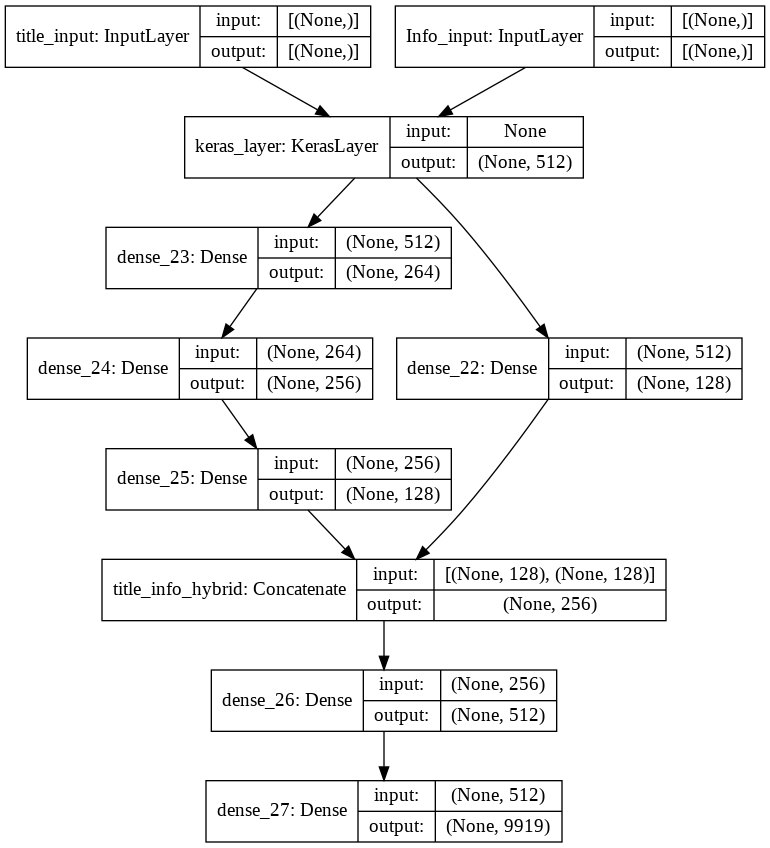

In [ ]:
# plotting the model 
tf.keras.utils.plot_model(mult_model,show_shapes= True)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data.TITLE.to_numpy().astype(np.str),test_data['BRAND'].to_numpy().astype(np.str)))

In [ ]:
predictions = mult_model.predict((test_data.TITLE.to_numpy().astype(np.str),test_data['BRAND'].to_numpy().astype(np.str)))

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission.head()

""


In [ ]:
submission.insert(0,'PRODUCT_ID',value = test_data.PRODUCT_ID)

In [ ]:
submission.head()

,PRODUCT_ID
0,1
1,2
2,3
3,4
4,5


In [ ]:
prediction_values = np.argmax(predictions,axis =1)

In [ ]:
submission.insert(1,'BROWSE_NODE_ID',prediction_values)

In [ ]:
submission.head()

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1140
1,2,2793
2,3,2637
3,4,604
4,5,7644


In [ ]:
submission.to_csv('/content/big_model_submission.csv',index=False)

In [ ]:
test_data.isna().sum()

PRODUCT_ID           0
TITLE                7
DESCRIPTION      10469
BULLET_POINTS     6786
BRAND             2430
dtype: int64

In [ ]:
big_model = tf.keras.models.load_model('/content/drive/MyDrive/mult_model')

In [ ]:
big_model.evaluate(training_dataset_1.take(2))

2/2 [==============================] - 1s 15ms/step - loss: 1.2085 - accuracy: 0.7344


[1.2085154056549072, 0.734375]

In [ ]:
test_data = test_data.fillna('NAN')

In [ ]:
predictions = big_model.predict((test_data.TITLE.to_numpy().astype(np.str),test_data.BRAND.to_numpy().astype(np.str)))

In [ ]:
prediction_values = np.argmax(predictions,axis =1)

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission.insert(0,'PRODUCT_ID',value = test_data.PRODUCT_ID)

In [ ]:
submission.insert(1,'BROWSE_NODE_ID',prediction_values)

In [ ]:
submission.head()

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1140
1,2,2793
2,3,2637
3,4,604
4,5,7644


In [ ]:
submission.to_csv('./basic_submission_2.csv')

In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext


In [ ]:
model_normalization = tf.keras.models.load_model('/content/drive/MyDrive/mult_model_normalization_correct')

In [ ]:
test_data.head()

,PRODUCT_ID,TITLE,DESCRIPTION,BULLET_POINTS,BRAND
0,1,"Command 3M Small Kitchen Hooks, White, Decorat...",Sale Unit: PACK,[INCLUDES - 9 hooks and 12 small indoor strips...,Command
1,2,O'Neal Jump Hardware JAG Unisex-Adult Glove (B...,Synthetic leather palm with double-layer thumb...,[Silicone printing for a better grip. Long las...,O'Neal
2,3,"NFL Detroit Lions Portable Party Fridge, 15.8 ...",Boelter Brands lets you celebrate your favorit...,[Runs on 12 Volt DC Power or 110 Volt AC Power...,Boelter Brands
3,4,Panasonic Single Line KX-TS880MX Corded Phone ...,Features: 50 Station Phonebook Corded Phone Al...,Panasonic Landline Phones doesn't come with a ...,Panasonic
4,5,Zero Baby Girl's 100% Cotton Innerwear Bloomer...,"Zero Baby Girl Panties Set. 100% Cotton, Breat...","[Zero Baby Girl Panties, Pack of 6, 100% Cotto...",Zero


In [ ]:
model_normalization.evaluate(training_dataset_1.take(2))

2/2 [==============================] - 2s 9ms/step - loss: 1.8197 - accuracy: 0.6406


[1.8197293281555176, 0.640625]

In [ ]:
predictions = model_normalization.predict((test_data.TITLE.to_numpy().astype(np.str),test_data.BRAND.to_numpy().astype(np.str)))

In [ ]:
prediction_values = predictions.argmax(axis= 1 )

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission.insert(0,'PRODUCT_ID',value = test_data.PRODUCT_ID)

In [ ]:
submission.insert(1,'BROWSE_NODE_ID',prediction_values)

In [ ]:
submission.head()

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1602
1,2,89
2,3,4
3,4,125
4,5,7644


In [ ]:
submission.to_csv('amazon_ML_submission.csv',index=False)

In [ ]:
print('hello')

hello


In [ ]:
base_layer_1 = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable = False)


In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
base_model_layer = base_layer_1(inputs)
lam_layer = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis =1))(base_model_layer)
x = tf.keras.layers.LSTM(564)(lam_layer)
x = tf.keras.layers.Dense(1080, activation= 'relu')(x)
outputs = tf.keras.layers.Dense(9919,activation='softmax')(x)

conv_model = tf.keras.Model(inputs, outputs)

(None, 1, 512)


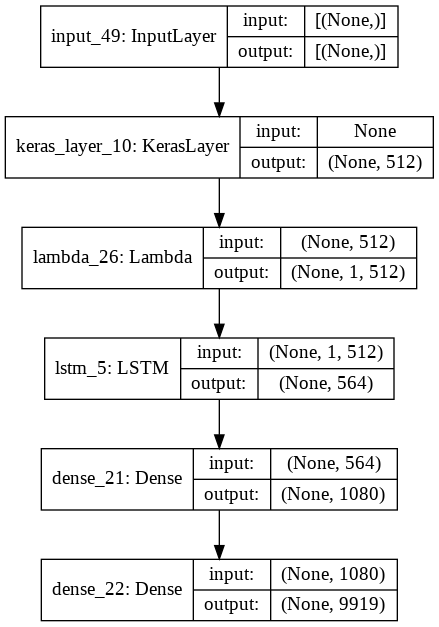

In [ ]:
tf.keras.utils.plot_model(conv_model,show_shapes=  True)

In [ ]:
conv_model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics =['accuracy']
)

conv_model_history = conv_model.fit(train_dataset,
                                    batch_size = 32, 
                                    steps_per_epoch = len(train_dataset)* 0.1 ,
                                    epochs = 5)

Epoch 1/5
8062/8062 [==============================] - 87s 10ms/step - loss: 2.3525 - accuracy: 0.5454
Epoch 2/5
8062/8062 [==============================] - 80s 10ms/step - loss: 1.5087 - accuracy: 0.6672
Epoch 3/5
8062/8062 [==============================] - 82s 10ms/step - loss: 1.3609 - accuracy: 0.6923
Epoch 4/5
8062/8062 [==============================] - 81s 10ms/step - loss: 1.2880 - accuracy: 0.7059
Epoch 5/5
8062/8062 [==============================] - 80s 10ms/step - loss: 1.2451 - accuracy: 0.7158


In [ ]:
conv_model.fit(train_dataset, batch_size = 32 , epochs = 3)

Epoch 1/3
80620/80620 [==============================] - 811s 10ms/step - loss: 1.1134 - accuracy: 0.7415
Epoch 2/3
80620/80620 [==============================] - 803s 10ms/step - loss: 1.0019 - accuracy: 0.7629
Epoch 3/3
80620/80620 [==============================] - 806s 10ms/step - loss: 0.9357 - accuracy: 0.7753


In [ ]:
conv_model.save('/content/drive/MyDrive/LSTM_MODEL_AMAZON')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/LSTM_MODEL_AMAZON/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/LSTM_MODEL_AMAZON/assets


In [ ]:
test_data.isna().sum()

PRODUCT_ID           0
TITLE                7
DESCRIPTION      10469
BULLET_POINTS     6786
BRAND             2430
dtype: int64

In [ ]:
test_data = test_data.fillna('NAN')

In [ ]:
test_data.isna().sum()

PRODUCT_ID       0
TITLE            0
DESCRIPTION      0
BULLET_POINTS    0
BRAND            0
dtype: int64

In [ ]:
LSTM_predictions  = conv_model.predict(test_data.TITLE.to_numpy().astype(np.str))

In [ ]:
LSTM_prediction_values = np.argmax(LSTM_predictions,axis =1)

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission.head()

""


In [ ]:
submission.insert(0,'PRODUCT_ID',value = test_data.PRODUCT_ID)

In [ ]:
submission.head()

,PRODUCT_ID
0,1
1,2
2,3
3,4
4,5


In [ ]:
submission.insert(1,'BROWSE_NODE_ID',LSTM_prediction_values)

In [ ]:
submission.head()

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1140
1,2,4
2,3,4
3,4,125
4,5,8915


In [ ]:
submission.to_csv('./LSTM_preds.csv')

# Bidirectional LSTM with 2 lstm starting "

In [ ]:
!nvidia-smi

Sat Jul 31 10:42:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def preprocess_dataframe(df,shuffle = True,drop_cols = ['DESCRIPTION' , 'BULLET_POINTS'] ,fill_na = True ):
  if shuffle: 
    df = df.sample(frac= 1 , random_state= 42)
  df = df.drop(df[df.BROWSE_NODE_ID > 9919].index,axis = 0 )
  if fill_na : 
    df = df.fillna(value = 'NAN')
  
  print(f'numrs of none values {df.isna().sum()}')
  return df 

  

In [ ]:
preprocessed_df = preprocess_dataframe(train_data)

numrs of none values TITLE             0
DESCRIPTION       0
BULLET_POINTS     0
BRAND             0
BROWSE_NODE_ID    0
dtype: int64


In [ ]:
LSTM_inputs = tf.data.Dataset.from_tensor_slices((preprocessed_df.TITLE.to_numpy().astype(np.str),preprocessed_df.BRAND.to_numpy().astype(np.str)))

In [ ]:
LSTM_outputs = tf.data.Dataset.from_tensor_slices(preprocessed_df.BROWSE_NODE_ID.to_numpy())

In [ ]:
LSTM_dataset = tf.data.Dataset.zip((LSTM_inputs, LSTM_outputs)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_layer_2 = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128/2', trainable = False)
base_layer_3 = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2',trainable = False)
base_layer_1 = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable = False)


In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
base_model_layer = base_layer_1(inputs)
lam_layer = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis =1))(base_model_layer)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(564,return_sequences=True))(lam_layer)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(564))(x)
x = tf.keras.layers.GRU(564, activation= 'tanh', return_sequences=True)(lam_layer)
x = tf.keras.layers.GRU(564)(x)

brand_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
y = base_layer_1(brand_inputs)
y = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis =1))(y)
# y  = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(564))(y)
# y = tf.keras.layers.LSTM(564)(y)
# y = tf.keras.layers.GRU(564)(y)
y = tf.keras.layers.GRU(564)(y)
y = tf.keras.layers.Dense(1080)(y)

concat = tf.keras.layers.concatenate(((x,y)))
z = tf.keras.layers.Dense(1080, activation= 'relu')(concat)
outputs = tf.keras.layers.Dense(9919,activation='softmax')(z)
GRU_MODEL_1 = tf.keras.Model((inputs, brand_inputs), outputs)

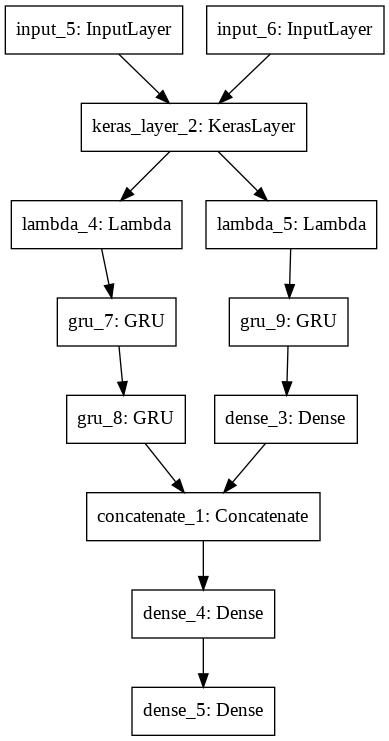

In [ ]:
tf.keras.utils.plot_model(GRU_MODEL_1)

In [ ]:
GRU_MODEL_1.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
GRU_MODEL_1.fit(LSTM_dataset,
                 steps_per_epoch= int(len(LSTM_dataset) * 0.1),
                 batch_size = 32,
                 epochs = 3)

Epoch 1/3
8062/8062 [==============================] - 181s 21ms/step - loss: 2.8545 - accuracy: 0.4677
Epoch 2/3
8062/8062 [==============================] - 172s 21ms/step - loss: 1.8319 - accuracy: 0.6077
Epoch 3/3
8062/8062 [==============================] - 170s 21ms/step - loss: 1.5782 - accuracy: 0.6508


In [ ]:
GRU_MODEL_1.fit(LSTM_dataset, 
                 batch_size = 32, 
                 epochs =3 )

Epoch 1/3
80622/80622 [==============================] - 1680s 21ms/step - loss: 1.2655 - accuracy: 0.7092
Epoch 2/3
80622/80622 [==============================] - 1678s 21ms/step - loss: 1.0945 - accuracy: 0.7435
Epoch 3/3
80622/80622 [==============================] - 1654s 21ms/step - loss: 1.0181 - accuracy: 0.7580


In [ ]:
GRU_MODEL_1.save('/content/drive/Shareddrives/Tabata/AMAZON_ML_GRU')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Tabata/AMAZON_ML_GRU/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Tabata/AMAZON_ML_GRU/assets


In [ ]:
def make_predictions(model, test_data,test_dataframe):
  predictions = model.predict(test_data)
  prediction_values = np.argmax(predictions,axis = 1)
  submission_dataframe = pd.DataFrame()
  submission_dataframe.insert(0,'PRODUCT_ID',value = test_dataframe.PRODUCT_ID)
  submission_dataframe.insert(1,'BROWSE_NODE_ID',prediction_values)
  print(submission_dataframe.head())
  return submission_dataframe


In [ ]:
test_data = test_data.fillna('NAN')

In [ ]:
submissoin = make_predictions(GRU_MODEL_1, test_data =(test_data.TITLE.to_numpy().astype(np.str),test_data.BRAND.to_numpy().astype(np.str)),test_dataframe = test_data)

In [ ]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import csv 
import tensorflow_hub as hub

In [ ]:
dududud = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim128/2', trainable = False)

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/Tabata/lstm/LSTM_1_MODEL/loaded_model.h5',custom_objects={'KerasLayer':dududud})

In [ ]:
train_path = '/content/drive/MyDrive/dataset/train.csv'
test_path = '/content/drive/MyDrive/dataset/test.csv'
sample_sub_path = '/content/drive/MyDrive/dataset/sample_submission.csv'

# Loading in the data 
train_data = pd.read_csv(train_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)

# Loading the test dataset 
test_data = pd.read_csv(test_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)
# # Sample submission 
sample_sub = pd.read_csv(sample_sub_path , escapechar = "\\" , quoting = csv.QUOTE_NONE)

In [ ]:
model.evaluate(LSTM_dataset.take(2))

2/2 [==============================] - 3s 64ms/step - loss: 0.9964 - accuracy: 0.7500


[0.9963921904563904, 0.75]

In [ ]:
test_data = test_data.fillna("NAN")

In [ ]:
test_data.head()

,PRODUCT_ID,TITLE,DESCRIPTION,BULLET_POINTS,BRAND
0,1,"Command 3M Small Kitchen Hooks, White, Decorat...",Sale Unit: PACK,[INCLUDES - 9 hooks and 12 small indoor strips...,Command
1,2,O'Neal Jump Hardware JAG Unisex-Adult Glove (B...,Synthetic leather palm with double-layer thumb...,[Silicone printing for a better grip. Long las...,O'Neal
2,3,"NFL Detroit Lions Portable Party Fridge, 15.8 ...",Boelter Brands lets you celebrate your favorit...,[Runs on 12 Volt DC Power or 110 Volt AC Power...,Boelter Brands
3,4,Panasonic Single Line KX-TS880MX Corded Phone ...,Features: 50 Station Phonebook Corded Phone Al...,Panasonic Landline Phones doesn't come with a ...,Panasonic
4,5,Zero Baby Girl's 100% Cotton Innerwear Bloomer...,"Zero Baby Girl Panties Set. 100% Cotton, Breat...","[Zero Baby Girl Panties, Pack of 6, 100% Cotto...",Zero


In [ ]:
predictoins = model.predict([test_data.TITLE.to_numpy().astype(np.str),
                            test_data.BRAND.to_numpy().astype(np.str)])

In [ ]:
pred_values = np.argmax(predictoins, axis = 1)

In [ ]:
pred_values

array([1140, 2572, 2143, ...,  800,  800, 3442])

In [ ]:
submission = pd.DataFrame()

In [ ]:
submission.insert(0, 'PRODUCT_ID', test_data.PRODUCT_ID)

In [ ]:
submission.insert(1,'BROWSE_NODE_ID',pred_values)

In [ ]:
submission.head()

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1140
1,2,2572
2,3,2143
3,4,407
4,5,8915


In [ ]:
submission.to_csv('dudududu.csv',index=False)

In [ ]:
from google.colab import files 
files.download('./dudududu.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install transformers 

     |████████████████████████████████| 2.6 MB 4.8 MB/s 
     |████████████████████████████████| 895 kB 32.1 MB/s 
     |████████████████████████████████| 3.3 MB 49.9 MB/s 
     |████████████████████████████████| 636 kB 60.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [ ]:
tokenizer.encode('fooking it salolwerkajsdflk aljsfd;lka jsflk;ajsfdlka sdflk; jasd;f',max_length=25,truncation=True)

[101,
 29379,
 6834,
 2009,
 16183,
 4747,
 29548,
 13006,
 16150,
 10258,
 2243,
 2632,
 22578,
 2546,
 2094,
 1025,
 1048,
 2912,
 1046,
 22747,
 13687,
 1025,
 19128,
 22747,
 102]

In [ ]:
train_data

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1
2,The Ultimate Self-Sufficiency Handbook: A Comp...,NaN,Skyhorse Publishing,imusti,2
3,Amway Nutrilite Kids Chewable Iron Tablets (100),NaN,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,3
4,Teacher Planner Company A4 6 Lesson Academic T...,NaN,NaN,NaN,4
...,...,...,...,...,...
2903019,Premium Aviator Sunglasses - HD Polarized (Bri...,These premium Aviator Sunglasses with 5 color ...,"[Frame size: Lens height - 56mm, Lens width - ...",Generic,1040
2903020,Social Distance Stickers - Set of 5 Sticker Sl...,set of 5 prints social distancing sticker self...,[covid19 safety sticker - set of 5 to maintain...,Generic,15199
2903021,Torr-to Face Shield PACK OF 5 with Adjustable ...,* COMPLETE FACE PROTECTION: Torr-to Face Shiel...,"[350 MICRONS PACK OF 5 PCS,COMPLETE FACE PROTE...",TORR-TO,1044933
2903022,Type-C to 3.5 MM for Oppo R17 Pro Type-C to 3....,Still want to use your favorite earphones/head...,"[Indian Connectors: Made for Indian sockets, t...",SHOPBELL,14790


In [ ]:
import re

In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext


In [ ]:
train_data['DESCRIPTION'] = train_data['DESCRIPTION'].to_numpy().astype(str).apply(cleanhtml)

In [ ]:
def preprocess_dataframe(df,shuffle = True,drop_cols = ['BULLET_POINTS'] ,fill_na = True ):
  if shuffle: 
    df = df.sample(frac= 1 , random_state= 42)
  df = df.drop(df[df.BROWSE_NODE_ID > 9919].index,axis = 0 )
  if fill_na : 
    df = df.fillna(value = 'NAN')
  
  print(f'numrs of none values {df.isna().sum()}')
  return df 

  

preprocessed_df = preprocess_dataframe(train_data)

LSTM_inputs = tf.data.Dataset.from_tensor_slices((preprocessed_df.DESCRIPTION.to_numpy().astype(np.str),preprocessed_df.BRAND.to_numpy().astype(np.str)))

LSTM_outputs = tf.data.Dataset.from_tensor_slices(preprocessed_df.BROWSE_NODE_ID.to_numpy())

LSTM_dataset = tf.data.Dataset.zip((LSTM_inputs, LSTM_outputs)).batch(32).prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
base_model_layer = base_layer_1(inputs)
lam_layer = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis =1))(base_model_layer)
x = tf.keras.layers.LSTM(564,return_sequences=True)(lam_layer)
x = tf.keras.layers.LSTM(564)(x)

brand_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)
y = base_layer_1(brand_inputs)
y = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis =1))(y)
y = tf.keras.layers.LSTM(564)(y)
y = tf.keras.layers.Dense(1080)(y)

concat = tf.keras.layers.concatenate(((x,y)))
z = tf.keras.layers.Dense(1080, activation= 'relu')(concat)
outputs = tf.keras.layers.Dense(9919,activation='softmax')(z)
LSTM_MODEL_1 = tf.keras.Model((inputs, brand_inputs), outputs)

tf.keras.utils.plot_model(LSTM_MODEL_1)

LSTM_MODEL_1.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

LSTM_MODEL_1.fit(LSTM_dataset,
                 steps_per_epoch= int(len(LSTM_dataset) * 0.1),
                 batch_size = 32,
                 epochs = 3)

# LSTM_MODEL_1.fit(LSTM_dataset, 
#                  batch_size = 32, 
#                  epochs =3 )